In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

In [2]:
data = np.loadtxt('LHC_data_2023.txt')
min(data), max(data), len(data)

(np.float64(20.0), np.float64(40.0), 100000)

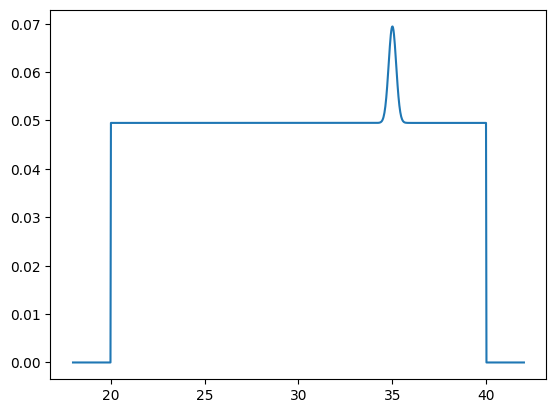

In [3]:
M = 35 # GeV

def pdf_bkg(x):
    return sp.stats.uniform(loc=min(data), scale=max(data)-min(data)).pdf(x)

def pdf(xm, m=35):
    a, b = (min(data) - m) / 0.2, (max(data) - m) / 0.2
    return (1-0.01)*sp.stats.uniform(loc=min(data), scale=max(data)-min(data)).pdf(xm) + 0.01*sp.stats.truncnorm(a, b, loc=m, scale=0.2).pdf(xm)
    return (1-0.01)*sp.stats.uniform(loc=min(data), scale=max(data)-min(data)).pdf(xm) + 0.01*sp.stats.norm(loc=m, scale=0.2).pdf(xm)

def gen_bkg(N):
    return sp.stats.uniform(loc=min(data), scale=max(data)-min(data)).rvs(N)

def gen_sig(N, m=35):
    return sp.stats.norm(loc=m, scale=0.2).rvs(N)

x = np.linspace(min(data)-2, max(data)+2, 1000)
plt.plot(x, pdf(x))

In [4]:
#sp.integrate.quad(lambda x: pdf(x, m=20), min(data), max(data))

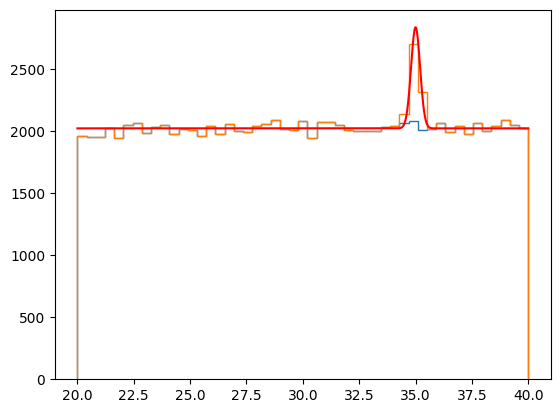

In [5]:
mc_bkg = gen_bkg(int(len(data)*0.99))
mc_sig = gen_sig(int(len(data)*0.01))

bins = np.linspace(min(data), max(data), 50)
bin_center = (bins[1:] + bins[:-1])/2

bkg_counts, bins = np.histogram(mc_bkg, bins=bins)
sig_counts, bins = np.histogram(mc_sig, bins=bins)

plt.stairs(bkg_counts, bins)
plt.stairs(sig_counts+bkg_counts, bins)

x = np.linspace(min(data), max(data), 1000)
plt.plot(x, pdf(x)*len(data)*np.diff(bins)[0], 'r')

In [6]:
def chi2(data, pred):
    return np.sum((data - pred)**2 / pred)

def chi2red(data, pred):
    return chi2(data, pred)/len(data)

pred = pdf_bkg(bin_center)*len(data)*np.diff(bins)[0]

In [7]:
def throw_toys(N):
    toy = []
    for _ in range(N):
        mc = gen_bkg(len(data))
        count, _ = np.histogram(mc, bins=bins)
        toy.append(chi2(count, pred))
    return toy

toys = throw_toys(1000)

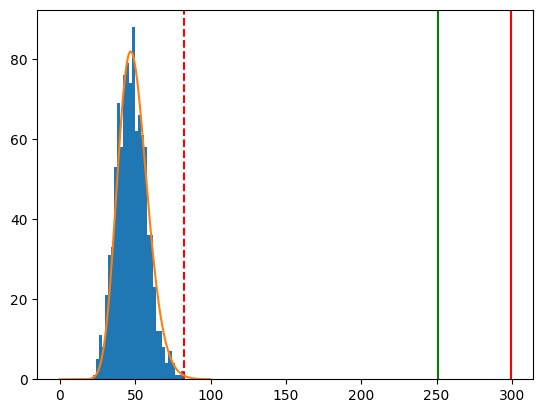

In [8]:
_, b, _ = plt.hist(toys, 30)
alpha = 1-sp.stats.norm.cdf(5)
chi2_crit = np.percentile(toys, 100*(1-alpha))
plt.axvline(chi2_crit, color='r', linestyle='--')

# plot chi2 distribution
x = np.linspace(0, 100, 1000)
plt.plot(
    x,
    sp.stats.chi2.pdf(x, len(bkg_counts))*len(toys) * np.diff(b)[0],
)

#sensitivity
chi2_signal = chi2(sig_counts+bkg_counts, pred)
plt.axvline(chi2_signal, color='r')

# unblind
data_counts, _ = np.histogram(data, bins=bins)
chi2_data = chi2(data_counts, pred)
plt.axvline(chi2_data, color='g')


In [9]:
p_value = sp.stats.chi2.sf(chi2_data, len(bkg_counts)-1)
p_value

np.float64(3.0022553402032506e-29)

In [10]:
significance = sp.stats.norm.ppf(1-p_value)
significance

np.float64(inf)

In [37]:
pred = pdf_bkg(bin_center)*len(data)*np.diff(bins)[0]

p_values_obs = []
for d, p in zip(data_counts, pred):
    chi2_nom = chi2(d,p)
    p_values_obs.append(sp.stats.chi2.sf(chi2_nom, 1))


In [38]:
bins = np.linspace(min(data), max(data), 50)
bin_center = (bins[1:] + bins[:-1])/2
pred = pdf_bkg(bin_center)*len(data)*np.diff(bins)[0]

p_values_obs = []
p_values_exp = []

for i,(d,p) in enumerate(zip(data_counts, pred)):
    #obs
    chi2_nom = chi2(d,p)
    p_values_obs.append(sp.stats.chi2.sf(chi2_nom, 1))

    #exp
    mc_bkg = gen_bkg(int(len(data)*0.99))
    mc_sig = gen_sig(int(len(data)*0.01), m=bin_center[i])

    bkg_counts, _ = np.histogram(mc_bkg, bins=bins)
    sig_counts, _ = np.histogram(mc_sig, bins=bins)

    b = bkg_counts
    s = sig_counts

    chi2_dn2 = chi2(s+b-2*np.sqrt(s),p)
    chi2_dn  = chi2(s+b-np.sqrt(s),p)
    chi2_nom = chi2(s+b,p)
    chi2_up  = chi2(s+b+np.sqrt(s),p)
    chi2_up2 = chi2(s+b+2*np.sqrt(s),p)
    p_values_exp.append(
        [
            sp.stats.chi2.sf(chi2_dn2, len(data_counts)),
            sp.stats.chi2.sf(chi2_dn, len(data_counts)),
            sp.stats.chi2.sf(chi2_nom, len(data_counts)),
            sp.stats.chi2.sf(chi2_up, len(data_counts)),
            sp.stats.chi2.sf(chi2_up2, len(data_counts))
        ]
        )

p_values_exp = np.array(p_values_exp)
p_values_obs = np.array(p_values_obs)


In [39]:
bins = np.linspace(min(data), max(data), 50)
bin_center = (bins[1:] + bins[:-1])/2
pred = pdf_bkg(bin_center)*len(data)*np.diff(bins)[0]

p_values_obs = []
p_values_exp = []

for i,(d,p) in enumerate(zip(data_counts, pred)):
    #obs
    chi2_nom = chi2(d,p)
    p_values_obs.append(sp.stats.chi2.sf(chi2_nom, 1))

    #exp
    mc_bkg = gen_bkg(int(len(data)*0.99))
    mc_sig = gen_sig(int(len(data)*0.01), m=bin_center[i])

    bkg_counts, _ = np.histogram(mc_bkg, bins=bins)
    sig_counts, _ = np.histogram(mc_sig, bins=bins)

    b = bkg_counts[i]
    s = sig_counts[i]

    chi2_dn2 = chi2(s+b-2*np.sqrt(s),p)
    chi2_dn  = chi2(s+b-np.sqrt(s),p)
    chi2_nom = chi2(s+b,p)
    chi2_up  = chi2(s+b+np.sqrt(s),p)
    chi2_up2 = chi2(s+b+2*np.sqrt(s),p)
    p_values_exp.append(
        [
            sp.stats.chi2.sf(chi2_dn2, 1),
            sp.stats.chi2.sf(chi2_dn, 1),
            sp.stats.chi2.sf(chi2_nom, 1),
            sp.stats.chi2.sf(chi2_up, 1),
            sp.stats.chi2.sf(chi2_up2, 1)
        ]
        )

p_values_exp = np.array(p_values_exp)
p_values_obs = np.array(p_values_obs)


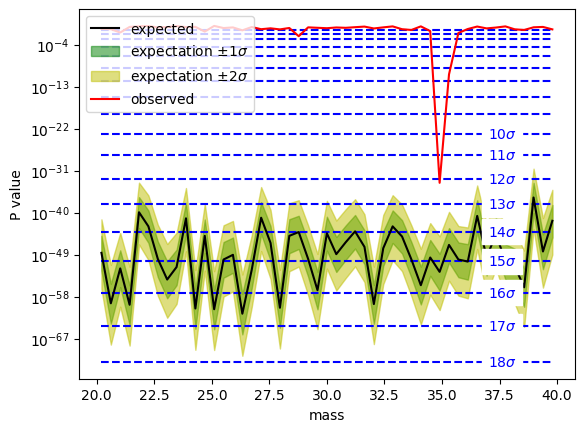

In [42]:
for i in range(1, 19):
    plt.plot(bin_center, [sp.stats.norm.sf(i) for _ in bin_center], 'b--')
    if i > 9:
        plt.text(37, sp.stats.norm.sf(i), f'${i}\sigma$', color='b', backgroundcolor='w', verticalalignment='center')
plt.plot(bin_center, p_values_exp[:,2], 'k', label='expected')
plt.fill_between(bin_center, p_values_exp[:,1], p_values_exp[:,-2], color='g', alpha=0.5, label=r'expectation $\pm1\sigma$')
plt.fill_between(bin_center, p_values_exp[:,0], p_values_exp[:,-1], color='y', alpha=0.5, label=r'expectation $\pm2\sigma$')
plt.plot(bin_center, p_values_obs, 'r', label='observed')
plt.yscale('log')

plt.xlabel('mass')
plt.ylabel('P value')

# plt.xlim(33,36)
plt.legend(loc='upper left')